In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
obj_lis  = Table.read('obj_lis_selected.fits')

### redshift of selected objs

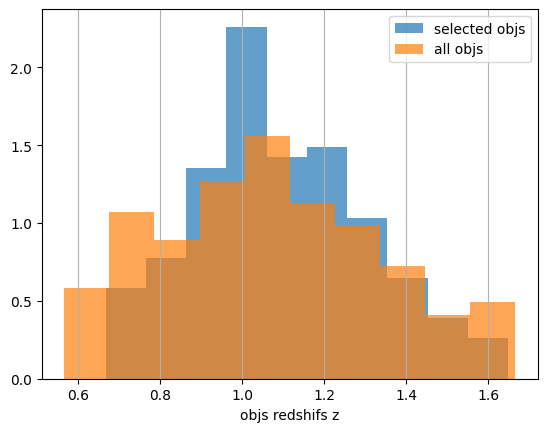

In [2]:
full_object_list = Table.read('full_object_catalog.fits')
obj_with_line = full_object_list[np.logical_and(full_object_list['Ha_FLUX']>0,full_object_list['Hb_FLUX']>0)]


plt.hist(obj_lis['z_MAP'],bins=10,alpha=0.7,density=True,label='selected objs')
plt.hist(obj_with_line['z_MAP'],bins=10,alpha=0.7,density=True,label='all objs')
plt.xlabel('objs redshifs z')
plt.grid(axis='x')
plt.legend()

## SFMS

### the following is the SFMS model from eq3 of Whitaker 2014

In [3]:
#the following is the SFMS model from 
# eq.3 & table 3 of Whitaker 2014
def z_10_15(m_array):
    sfr = np.zeros(len(m_array))
    sfr_err = np.zeros(len(m_array))
    lowmass = m_array<10.2
    sfr[lowmass]     = 0.99 * (m_array[lowmass]-10.2) + 1.31 
    sfr_err[lowmass] = np.sqrt((0.04*(m_array[lowmass]-10))**2 + 0.02**2)
    highmass = m_array >= 10.2  
    sfr[highmass]     = 0.51 * (m_array[highmass]-10.2) + 1.31
    sfr_err[highmass] = np.sqrt((0.07*(m_array[highmass]-10))**2 + 0.02**2)
    return sfr,sfr_err

def z_05_10(m_array):
    sfr = np.zeros(len(m_array))
    sfr_err = np.zeros(len(m_array))
    lowmass = m_array<10.2
    sfr[lowmass]     = 0.94 * (m_array[lowmass]-10.2) + 1.11
    sfr_err[lowmass] = np.sqrt((0.03*(m_array[lowmass]-10))**2 + 0.03**2)
    highmass = m_array >= 10.2  
    sfr[highmass]     = 0.14 * (m_array[highmass]-10.2) + 1.11
    sfr_err[highmass] = np.sqrt((0.08*(m_array[highmass]-10))**2 + 0.03**2)
    return sfr,sfr_err

def SFMS_model(m_min,m_max):
    m = np.linspace(m_min,m_max,30)
    sfr_1_l = z_05_10(m)[0] - z_05_10(m)[1]
    sfr_1_h = z_05_10(m)[0] + z_05_10(m)[1]
    sfr_2_l = z_10_15(m)[0] - z_10_15(m)[1]
    sfr_2_h = z_10_15(m)[0] + z_10_15(m)[1]
    return m, sfr_1_l, sfr_1_h, sfr_2_l, sfr_2_h

### SFMS of selected objects

/tmp/ipykernel_11004/408750467.py:1: RuntimeWarning: invalid value encountered in log10
  logmass = np.log10(obj_lis['mass'])
/tmp/ipykernel_11004/408750467.py:2: RuntimeWarning: invalid value encountered in log10
  logsfr  = np.log10(obj_lis['sfr'])
/tmp/ipykernel_11004/408750467.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(Table.read('full_object_catalog.fits')['mass']),
/tmp/ipykernel_11004/408750467.py:8: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(Table.read('full_object_catalog.fits')['mass']),
/tmp/ipykernel_11004/408750467.py:9: RuntimeWarning: divide by zero encountered in log10
  np.log10(Table.read('full_object_catalog.fits')['sfr']),
/tmp/ipykernel_11004/408750467.py:9: RuntimeWarning: invalid value encountered in log10
  np.log10(Table.read('full_object_catalog.fits')['sfr']),


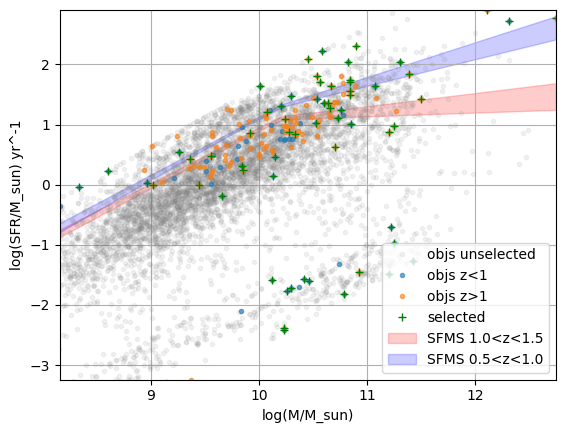

In [16]:
logmass = np.log10(obj_lis['mass'])
logsfr  = np.log10(obj_lis['sfr'])
low_z   = obj_lis['z_MAP']<1.0
high_z  = obj_lis['z_MAP']>1.0
agn     = np.logical_or(obj_lis['tag'] == 'agn',obj_lis['manual_select'] =='selected')
#agn     = obj_lis['tag'] == 'agn'

plt.plot(np.log10(Table.read('full_object_catalog.fits')['mass']),
         np.log10(Table.read('full_object_catalog.fits')['sfr']),
         color='grey',linewidth=0,marker='.',alpha=0.1,label='objs unselected')
plt.plot(logmass[low_z] ,logsfr[low_z], linewidth=0,marker='.',alpha=0.6,label='objs z<1')
plt.plot(logmass[high_z],logsfr[high_z],linewidth=0,marker='.',alpha=0.6,label='objs z>1')
plt.plot(logmass[agn],logsfr[agn],linewidth=0,marker='+',alpha=1,color='g',label='selected')


plt.xlim(np.nanmin(logmass),np.nanmax(logmass))
plt.ylim(np.nanmin(logsfr),np.nanmax(logsfr))

m, sfr_1_l, sfr_1_h, sfr_2_l, sfr_2_h = SFMS_model(np.nanmin(logmass),np.nanmax(logmass))
plt.fill_between(m, sfr_1_l,sfr_1_h, 
                color="r", alpha=0.2,label='SFMS 1.0<z<1.5') 
plt.fill_between(m, sfr_2_l,sfr_2_h, 
                color="b", alpha=0.2,label='SFMS 0.5<z<1.0')
plt.grid();plt.legend()
plt.xlabel('log(M/M_sun)')
plt.ylabel('log(SFR/M_sun) yr^-1')
plt.show()

mass binning
9 9.75   9.75 10.5    10.5~